# **OID Type**

**OID(Object Identifier)**

- Postgresql DBMS 은 시스템 자신의 내부에 있는 객체(ex: table, index, sequence, etc...)들을 구분하기 위해서 특별한 타입


- DBMS 내의 스키마 정보를 보관하는 system catalogs 테이블의
한 종류인 pg_attribute 입니다. 보시면 oid 타입을 사용하는 걸 확인



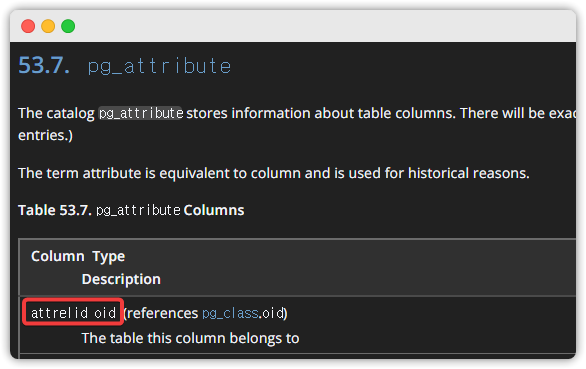

- Postgresql DBMS 는 각 테이블, 인덱스 등의 객체들이 생성될 때마다
각자 고유한 OID 값 (범위: unsigned integer)을 자동으로 부여.

- 매순간 객체를 생성하면 무조건 OID 값이 할당.



```sql
create table public.users(id int, name varchar(200));
select 'public.users'::regclass::oid;
```



# **RegClass Type**

- 가끔 System_Catalog을 조회하거나, OID 값을 통해서 뭔가를 해야되는 경우도 있다.
- 문제는 그때마다 일일이 Db Object 에 매칭되는 OID 를 찾아봐야 함.



```sql
-- `pg_class`, `pg_attribute` 둘 다 system table.
SELECT * FROM pg_attribute
  WHERE attrelid = (SELECT oid FROM pg_class WHERE relname = 'users');
```

- Postgresql 에서는 RegClass Type 을 제공하여 이를 방지

```sql
-- pg_attribute.attrelid 의 column type 은 oid!
SELECT * FROM pg_attribute WHERE attrelid = 'public.users'::regclass;

```

- 단순히 table 명칭(public.users)을 regclass 로 타입 캐스팅한
것만으로도 oid type 컬럼(attrelid) 과 비교 연산이 가능



- RegClass Type 은 OID Type 엄연히 다른 타입인데 = 연산이 되는 게 의문?
  - 가능한 이유는 RegClass Type 은 OID Type 을 기반으로 만들어진 Alias 타입이기
  때문.
  - 그래서 OID 와 관련된 연산을 수행할 때 OID 가 아닌 RegClass 타입의
  피연산자를 사용하더라도 Postgresql DBMS 가 알아서 연산이 되도록 처리.


- RegClass 는 OID 와의 연산 기능만 제공하는 게 아님.
  - OID::RegClass 처럼 캐스팅하면 OID 와 매치되는 Object 의 이름을 추출할 수 있다.



```Sql
select 'users'::regclass::oid; --users 가 출력
select 25015::regclass;
```


**nextval 테스트**

- OID 를 인자로 받는 다양한 Built-in Function 들이 존재.
- 대표적으로 Sequence 의 다음값을 받아오는 nextval function 이 있다.

- nextval 을 사용해서 정말로 OID, RegClass 타입을 인자를 받아서
제대로 동작하는지 확인.



```sql
create sequence public.test_seq;

-- regclass Type
select nextval('public.test_seq'::regclass);

-- oid Type
select nextval('public.test_seq'::regclass::oid);

-- oid 의 정수값을 통해서도 가능
select to_regclass('public.test_seq')::oid; -- 25386 조회됨
select nextval(25386);

-- 단순 문자열도 가능
select nextval('public.test_seq');
```



- 마지막의 nextval 에서는 regclass 타입도 아닌 일반 문자열 타입을 사용했는데도,
nextval 이 제대로 동작하는 것을 확인.

- 동작 방식이 가능한 건 Postgresql DBMS 가 자체적으로 바꿔주는 것이기 때문.




**참고: WITH OIDS - Deprecated**

- postgresql 12 이전 버전 에서는 create table 문법에서 OID 관련된
문법(WITH OIDS)이 존재.



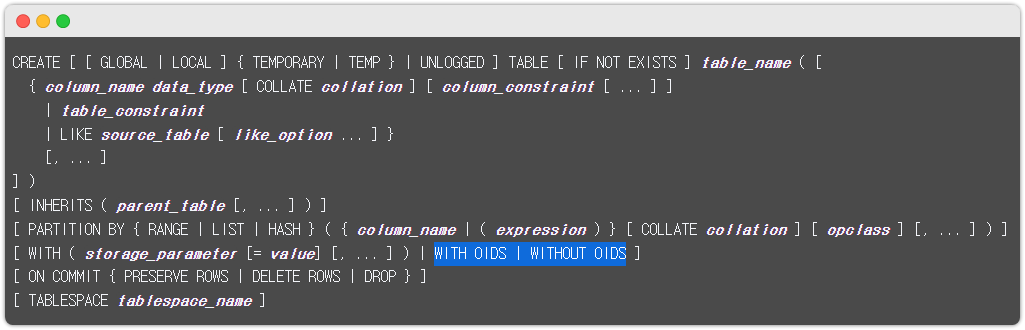

- WITH OIDS 를 세팅하면 사용자가 생성한 table 에는 OID (숨김) 컬럼이 생성되고,
해당 컬럼에 값이 자동으로 들어갑니다.
 -  이를 통해서 table 의 각 ROW 에 매칭되는 고유한 값인 OID 가 생성.

- OID 는 unsigned integer 만큼의 값만 갖을 수 있기 때문에 사용자들의 테이블이 추후에 얼마나 데이터가 많이 생길지 모르는 상태에서 무분별하게 OID 가 사용되는 것은 큰 문제를 일으킬 수 있음.

- 이를 문제 삼은 Postgresql 은 결국 12 버전 이후부터 직접적으로 WITH OIDS 문법을 사용한 Create Table Syntax 를 제공하지 않도록 조치.
- 이외에도 어떠한 방식으로도 table row 에 OID 세팅하는 방법을 일체 없애버림.



> postgresql 12 버전 이전을 사용하시는 분들이더라도 부디 테이블에 OID column
을 생성하는 문법은 사용하지 마시기 바랍니다. 애초에 시스템 테이블이 사용하려는 건데,
그걸 가져다 사용할 이유가 없음. 각 테이블에 맞는 기본키를 제공.



